<a href="https://colab.research.google.com/github/Michal-Janulewski/Machine_Learning/blob/main/Prediction_of_airplane_price_tickets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import urllib.request

In [ ]:
#Pobieramy dane z githuba
data_train = pd.read_csv("https://raw.githubusercontent.com/Michal-Janulewski/Machine_Learning/main/Data_Train.csv", sep = ";")

In [ ]:
#Sprawdzamy czy dane mają brakujące wartości
data_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [ ]:
#Brakujących wartości jest bardzo mało więc możemy je po prostu usunąć
data_train.dropna(inplace = True)

In [ ]:
#Sprawdzamy czy istnieją zduplikowane wartości
data_train[data_train.duplicated()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303
...,...,...,...,...,...,...,...,...,...,...,...
10594,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,12:35 28 Jun,13h 30m,2 stops,No info,12819
10616,Jet Airways,1/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 02 Jun,26h 55m,2 stops,No info,13014
10634,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 07 Jun,26h 55m,2 stops,In-flight meal not included,11733
10672,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,19:00 28 Jun,19h 55m,2 stops,In-flight meal not included,11150


In [ ]:
#Usuwamy zduplikowane wartości
data_train.drop_duplicates(keep="first",inplace=True)

In [ ]:
#Sprawdzamy typ danych w poszczególnych kolumnach
data_train.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [ ]:
#Funkcja która zamienia dane w kolumnie na typ "datetime"
def change_to_datetime(df,col):
  df[col] = pd.to_datetime(df[col])

In [ ]:
# Lista df i kolumn do przekształcenia
datasets_and_columns = [
    (data_train, ["Date_of_Journey", "Dep_Time", "Arrival_Time"])
]

# Iteracja po parach (dataset, columns) i stosowanie funkcji change_to_datetime
for dataset, columns in datasets_and_columns:
    for column in columns:
        change_to_datetime(dataset, column)

In [ ]:
#Sprawdzamy tym danych w poszczególnych kolumnach
data_train.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [ ]:
#Tworzymy kolumny numeryczne przedstawiające dzień i miesiąc podróży, a następnie usuwamy już nie potrzebną kolumne "Date_of_Journey" za pomocą wcześniej zdefinijowanej funkcji
def day_and_month(df, col):
    df["journey_day"] = df[col].dt.day
    df["journey_month"] = df[col].dt.month
    df.drop(col, axis=1, inplace=True)

datasets_and_column = [
    (data_train, "Date_of_Journey")
]

for dataset, column in datasets_and_column:
    day_and_month(dataset, column)

In [ ]:
#Tworzymy kolumny numeryczne przedstawiające godzine i minute odlotu jak i przylotu, a nastepnie usuwamy nie potrzebne już kolumny "Dep_Time" i "Arrival_Time"
data_train["Dep_Time_Hour"] = data_train["Dep_Time"].dt.hour
data_train["Dep_Time_Min"] = data_train["Dep_Time"].dt.minute

data_train["Arrival_Time_Hour"] = data_train["Arrival_Time"].dt.hour
data_train["Arrival_Time_Min"] = data_train["Arrival_Time"].dt.minute

data_train.drop(["Dep_Time", "Arrival_Time"], axis = 1, inplace = True)

In [ ]:
#Format kolumny "Duration" xx[h]:xx[m] zamieniamy na format numeryczny w postaci samych minut
data_train['Duration'] = data_train['Duration'].apply(lambda x: eval(x.replace("h", '*60').replace(' ','+').replace('m','*1')))

In [ ]:
#Wartości z kolumny "Total_Stops" zamineniamy na wartości numeryczne
data_train['Total_Stops'].replace(['non-stop','1 stop', '2 stops', '3 stops', '4 stops'], [0, 1, 2, 3, 4], inplace=True)

In [ ]:
#Sprawdzamy ilość lotów danych linii lotniczych
data_train["Airline"].value_counts()

Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [ ]:
#Dane treningowe
all_row = data_train["Airline"].count()
airline_counts = data_train["Airline"].value_counts()

# Sprawdzamy loty których linii stanowią mniej niż 1% wszystkich lotów
airline_outlier = (airline_counts / all_row) * 100 < 1

# Zamienieniamy nazwe linii lotniczych które stonowią mniej niż 1% wszytkich lotów na "Other"
for airline in data_train["Airline"].unique():
    if airline_outlier.get(airline, False):
        data_train["Airline"].replace({airline: 'Other'}, inplace=True)

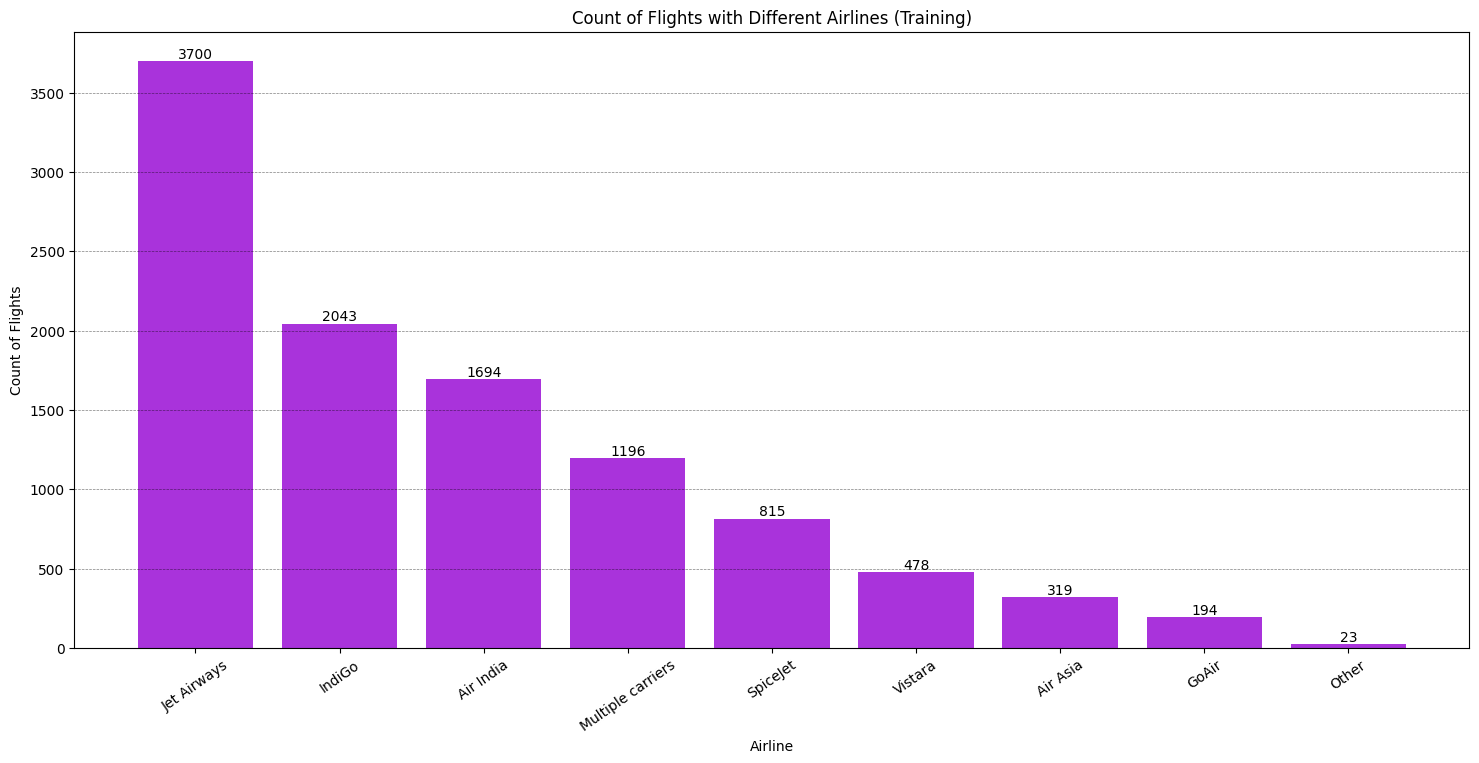

In [ ]:
airlines_sort = data_train.groupby("Airline").size().sort_values(ascending=False).index

fig, ax = plt.subplots(figsize=(18, 8))

# Plot for the training data
ax.bar(x=airlines_sort, height=data_train["Airline"].value_counts()[airlines_sort], color="darkviolet", alpha=0.8)
ax.set_title("Count of Flights with Different Airlines (Training)")
ax.set_xlabel("Airline")
ax.set_ylabel("Count of Flights")
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.5, color="black")
ax.bar_label(ax.containers[0], fmt='%.0f', fontsize=10, color="black")
ax.set_xticks(np.arange(len(airlines_sort)))
ax.set_xticklabels(airlines_sort, rotation = 35)

plt.show()

In [ ]:
#Sprawdzamy ilość poszczególnych dodatkowych informacji związanych z lotami
data_train["Additional_Info"].value_counts()

No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [ ]:
data_train["Additional_Info"] = data_train["Additional_Info"].replace({"No Info": "No info"})

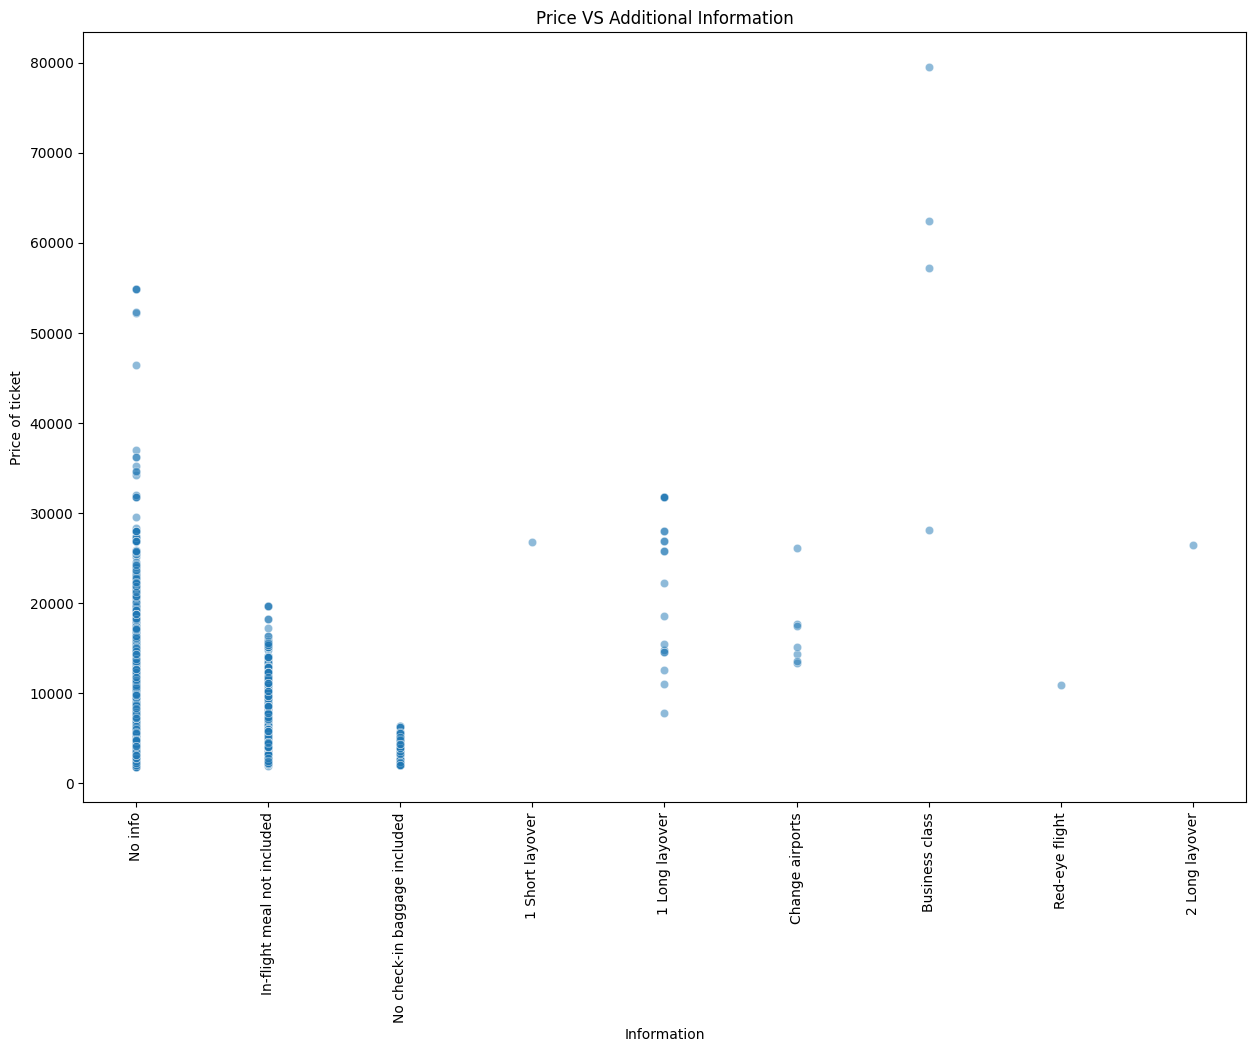

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 10))
plt.title('Price VS Additional Information')

sns.scatterplot(x='Additional_Info', y='Price', data=data_train, alpha=0.5)

plt.xticks(rotation=90)
plt.xlabel('Information')
plt.ylabel('Price of ticket')

plt.show()

In [ ]:
#Dane treningowe
all_row = data_train["Additional_Info"].count()
info_counts = data_train["Additional_Info"].value_counts()

# Sprawdzamy dodatkowe informacje o lotach które stanowią mniej niż 1% wszystkich lotów
info_one_percent = (info_counts / all_row) * 100 < 1

# Zamienieniamy dodatkowe informacje które stonowią mniej niż 1% wszytkich na "Other"
for info in data_train["Additional_Info"].unique():
    if info_one_percent.get(info, False):
        data_train["Additional_Info"].replace({info: 'Other'}, inplace=True)

In [ ]:
#Utworzenie nowego zbioru danych który nie zawiera kolumny z ceną biletu
data = data_train.drop(["Price"], axis = 1)

In [ ]:
data.dtypes

Airline              object
Source               object
Destination          object
Route                object
Duration              int64
Total_Stops           int64
Additional_Info      object
journey_day           int64
journey_month         int64
Dep_Time_Hour         int64
Dep_Time_Min          int64
Arrival_Time_Hour     int64
Arrival_Time_Min      int64
dtype: object

In [ ]:
#Podział danych na zbiór wartości kategorialnych i zbiór wartości numerycznych
data_train_cat = data.select_dtypes(exclude="int64")
data_train_num = data.select_dtypes(include = "int64")

In [ ]:
data_train_cat.head()

,Airline,Source,Destination,Route,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR → DEL,No info
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,No info
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,No info
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,No info
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,No info


In [ ]:
#Przekształcenie danych kategorialnych na numeryczne za pomocą LabelEncoder, które przypisują unikalną liczbę całkowitą każdej unikalnej wartości w danej kolumnie
from sklearn.preprocessing import LabelEncoder

data_train_cat = data_train_cat.apply(LabelEncoder().fit_transform)

In [ ]:
data_train_cat.head()

,Airline,Source,Destination,Route,Additional_Info
0,3,0,5,18,2
1,1,3,0,84,2
2,4,2,1,118,2
3,3,3,0,91,2
4,3,0,5,29,2


In [ ]:
#Połączenie dwóch zbiorów danych w jeden
final_train_data = pd.concat([data_train_cat, data_train_num], axis = 1)
price = data_train["Price"]

In [ ]:
final_train_data.head()

,Airline,Source,Destination,Route,Additional_Info,Duration,Total_Stops,journey_day,journey_month,Dep_Time_Hour,Dep_Time_Min,Arrival_Time_Hour,Arrival_Time_Min
0,3,0,5,18,2,170,0,24,3,22,20,1,10
1,1,3,0,84,2,445,2,5,1,5,50,13,15
2,4,2,1,118,2,1140,2,6,9,9,25,4,25
3,3,3,0,91,2,325,1,5,12,18,5,23,30
4,3,0,5,29,2,285,1,3,1,16,50,21,35


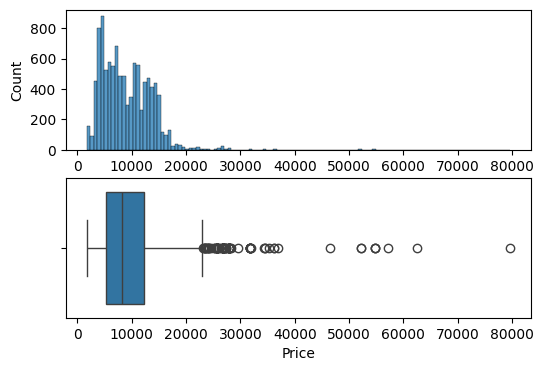

In [ ]:
#Rozkład cen przedstawiony na histogramie i wykresie pudełkowym
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
sns.histplot(price, ax=ax)
sns.boxplot(price, ax=ax2, orient='h')

plt.show()

In [ ]:
#Zastąpienie wartości odstających czyli tych gdzie cena przekracza 40000 medianą cen
price = np.where(price >= 40000, price.median(),price)

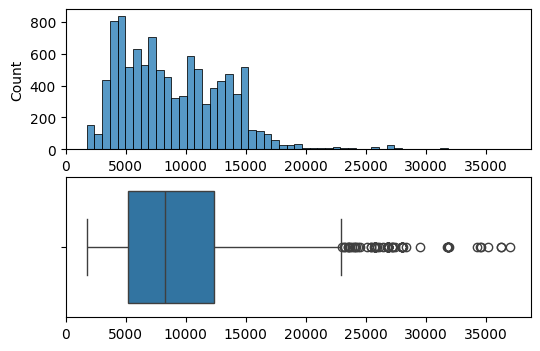

In [ ]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(6, 4))
sns.histplot(price, ax=ax)
sns.boxplot(price, ax=ax2, orient='h')

plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif

In [ ]:
#Obliczenie wskaźnika informacyjnego między zmiennymi niezależnym (final_train_data), a zmienną zależną (price). Współczynni mierzy jak bardzo informacje o jednej zmiennej
#pomagają przewidzieć wartość drugiej zmiennej
mutual_info_classif(final_train_data, price)

array([2.21462797, 2.44252726, 1.09134823, 2.33128057, 2.09042847,
       0.98023282, 1.95678131, 0.50531886, 1.08726736, 1.14407739,
       0.80655236, 1.17844506, 0.9284716 ])

In [ ]:
#Wartośći wskaźnika informacyjnego zapisaliśmy za pomocą df, gdzie indeksem są kolumny zbioru danych (final_train_data)
imp = pd.DataFrame(mutual_info_classif(final_train_data, price),index=final_train_data.columns)
imp

,0
Airline,2.174546
Source,2.441673
Destination,1.094403
Route,2.368444
Additional_Info,2.116333
Duration,0.978990
Total_Stops,1.972970
journey_day,0.497937
journey_month,1.071304
Dep_Time_Hour,1.159560


In [ ]:
#Wartości wskaźnika zostały posorotwane w kolejności malejącej
imp.columns = ["importance"]
imp.sort_values(by='importance',ascending=False)

,importance
Source,2.441673
Route,2.368444
Airline,2.174546
Additional_Info,2.116333
Total_Stops,1.972970
Arrival_Time_Hour,1.207751
Dep_Time_Hour,1.159560
Destination,1.094403
journey_month,1.071304
Duration,0.978990


In [ ]:
#Podział danych na zestaw treningowy i testowy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_train_data, price, test_size = 0.2, random_state = 42)

In [ ]:
#Zbudowanie modelu regresji za pomocą alorytmu lasów losowych. Została przyjęta domyślna ilość drzew, a więc 100, a parametr random_state ustawiliśmy na 42 tak jak przy podziale
#danych na zestaw treningowy i testowy.
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(random_state=42)
reg_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
#Przewidywanie wartości docelowe (y_pred) na podstawie danych testowych (X_test)
#przy użyciu modelu reg_ef
y_pred = reg_rf.predict(X_test)

In [ ]:
#Współczynnik determinacji R^2 na danych treningowych.
reg_rf.score(X_train, y_train)

0.9845878408111606

In [ ]:
#Współczynnik determinacji R^2 na danych testowych.
reg_rf.score(X_test, y_test)

0.894324940440535

<ipython-input-42-baff298e86f5>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_pred)


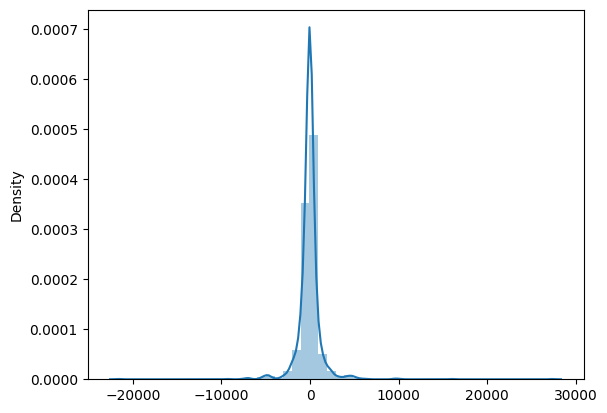

In [ ]:
#Tworzy wykres rozkłądu różnic pomiędzy testowymi i treningowymi wartościami. Pozwala ocenić jak dobrze model przewiduje rzeczywiste wartości oraz czy istnieją pewne wzorce w błedach przewidywania.
sns.distplot(y_test-y_pred)
plt.show()

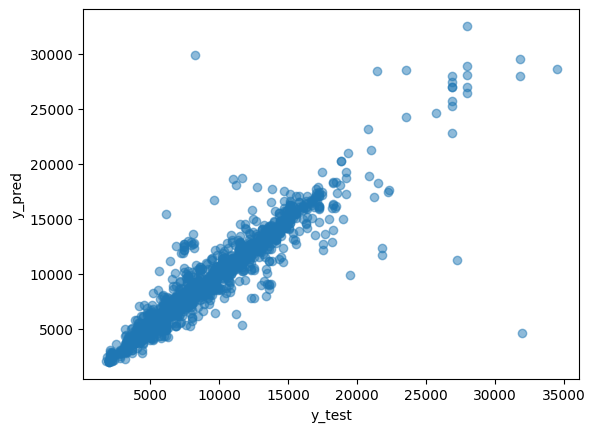

In [ ]:
#Wykres punktowy gdzie na osi x znajdują się wartości prawdziwe a na osi y prognozowane wartości
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [ ]:
from sklearn import metrics
MAE = metrics.mean_absolute_error(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)

MAE: 648.643448697093
MSE: 2096957.2768118568
RMSE: 1448.0874548216543


In [ ]:
# Normalizacja RMSE

RMSE/(max(price)-min(price))

0.041110818045129865

In [ ]:
#Współczynnik determinacji R^2
metrics.r2_score(y_test, y_pred)

0.894324940440535

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Liczba drzew w lesie losowym
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Cechy brane pod uwagę przy podziale węzła
max_features = ['auto', 'sqrt']
# Maksymalna głębokość każdego drzewa  lesie
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimalna liczba próbki wymagana do podziału węzła
min_samples_split = [2, 5, 10, 15, 100]
# Minimalna liczba próbek wymagana w liściu węzła
min_samples_leaf = [1, 2, 5, 10]

In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [ ]:
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [ ]:
rf_random.fit(X_train,y_train)

In [ ]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [ ]:
prediction = rf_random.predict(X_test)

<ipython-input-55-b322b1d393bd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


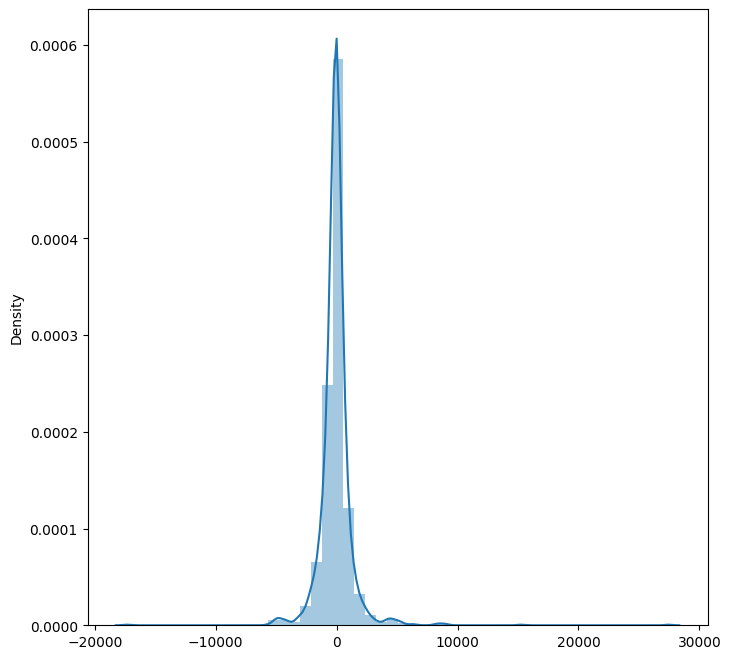

In [ ]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

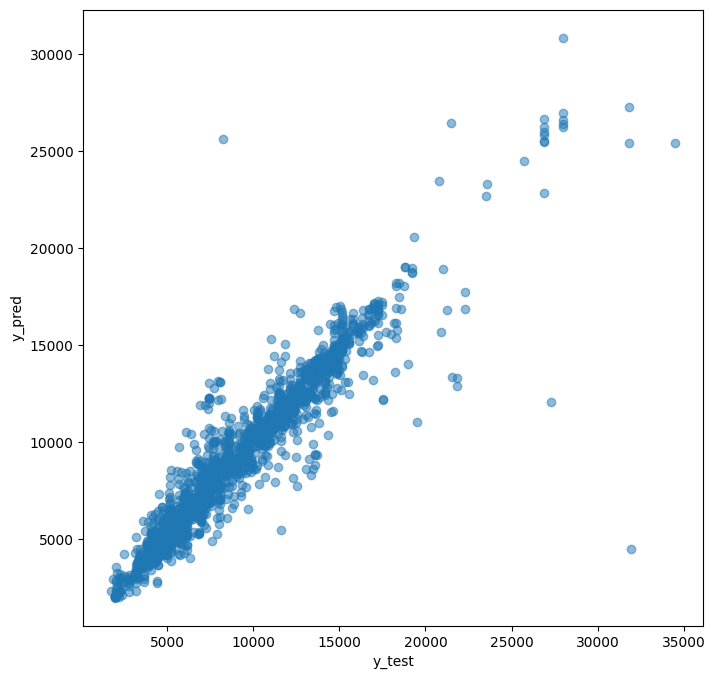

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 723.3902515408512
MSE: 1998737.7111199389
RMSE: 1413.7672054195978


In [ ]:
metrics.r2_score(y_test,prediction)

0.8992746638179129